In [13]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Goals

# Takeaways

# Plan

# Acquire

- read in master .csv file of original 8 .csv files.

- read in 225 rows and 9 columns.

- read in file with 'Date' column as DatetimeIndex.

In [14]:
df = pd.read_csv('fitbit_master.csv', index_col='Date', parse_dates=True)

In [15]:
df.shape

(225, 9)

# Prepare

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
Calories Burned           225 non-null int64
Steps                     225 non-null int64
Distance                  225 non-null float64
Floors                    225 non-null int64
Minutes Sedentary         225 non-null int64
Minutes Lightly Active    225 non-null int64
Minutes Fairly Active     225 non-null int64
Minutes Very Active       225 non-null int64
Activity Calories         225 non-null int64
dtypes: float64(1), int64(8)
memory usage: 17.6 KB


## Resample by Day by Sum

In [17]:
df.resample('D').sum()

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2018-04-26,2635,2931,1.4,2,1347,93,0,0,566
2018-04-27,3649,9971,4.7,19,1158,219,46,17,1752
2018-04-28,3379,3521,1.7,2,702,155,22,11,1124
2018-04-29,2851,1639,0.8,0,891,122,0,0,602
2018-04-30,2825,1323,0.6,0,880,104,0,0,540
2018-05-01,3292,2581,1.2,0,919,167,13,2,1068
2018-05-02,2660,1372,0.7,0,927,90,0,0,419
2018-05-03,3121,2232,1.1,0,876,157,16,0,1006
2018-05-04,2522,904,0.4,1,1012,61,0,0,269


## Check Latest Date

- 2018-12-06

- projection will be two weeks out from this date

In [18]:
df.index.max()

Timestamp('2018-12-06 00:00:00')

In [19]:
df.index.min()

Timestamp('2018-04-26 00:00:00')

## Rename Columns

In [20]:
df.columns

Index(['Calories Burned', 'Steps', 'Distance', 'Floors', 'Minutes Sedentary',
       'Minutes Lightly Active', 'Minutes Fairly Active',
       'Minutes Very Active', 'Activity Calories'],
      dtype='object')

In [21]:
df = df.rename(columns={'Calories Burned': 'calories_burned', 'Steps': 'steps', 'Distance': 'distance', 
                  'Floors': 'floors', 'Minutes Sedentary': 'sedentary_mins', 'Minutes Lightly Active': 'lightly_active_mins',
                  'Minutes Fairly Active': 'fairly_active_mins', 'Minutes Very Active': 'very_active_mins', 
                'Activity Calories': 'activity_calories'})

In [22]:
df.head()

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories
Date,,,,,,,,,
2018-04-26,2635,2931,1.4,2,1347,93,0,0,566
2018-04-27,3649,9971,4.7,19,1158,219,46,17,1752
2018-04-28,3379,3521,1.7,2,702,155,22,11,1124
2018-04-29,2851,1639,0.8,0,891,122,0,0,602
2018-04-30,2825,1323,0.6,0,880,104,0,0,540


## Add column with total of all activity

In [23]:
df['active_total'] = df.lightly_active_mins + df.fairly_active_mins + df.very_active_mins

## Add column with ratio of active time to sedentary time

In [24]:
df['ratio_act_sed'] = df.active_total/df.sedentary_mins

## Add column with ratio of steps to distance

In [25]:
df['ratio_steps_distance'] = df.steps/df.distance

## Add column with ratio of calories to steps

In [26]:
df['ratio_cal_steps'] = df.calories_burned/df.steps

## Add column with ratio of active time to calories

In [27]:
df['ratio_active_cal'] = df.active_total/df.calories_burned

## Add column with ratio of sedentary time to calories

In [28]:
df['ratio_sed_cal'] = df.sedentary_mins/df.calories_burned

## Add a Month Column

In [29]:
df['month'] = df.index.month

## Add a Day of the Week Column

In [30]:
df['weekday'] = df.index.strftime('%w %a')

In [31]:
df.head()

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,ratio_act_sed,ratio_steps_distance,ratio_cal_steps,ratio_active_cal,ratio_sed_cal,month,weekday
Date,,,,,,,,,,,,,,,,,
2018-04-26,2635,2931,1.4,2,1347,93,0,0,566,93,0.069042,2093.571429,0.899011,0.035294,0.511195,4,4 Thu
2018-04-27,3649,9971,4.7,19,1158,219,46,17,1752,282,0.243523,2121.489362,0.365961,0.077281,0.317347,4,5 Fri
2018-04-28,3379,3521,1.7,2,702,155,22,11,1124,188,0.267806,2071.176471,0.959671,0.055638,0.207754,4,6 Sat
2018-04-29,2851,1639,0.8,0,891,122,0,0,602,122,0.136925,2048.750000,1.739475,0.042792,0.312522,4,0 Sun
2018-04-30,2825,1323,0.6,0,880,104,0,0,540,104,0.118182,2205.000000,2.135299,0.036814,0.311504,4,1 Mon


# Explore

- Begin stage with 225 rows, 17 columns

- 33 Thursdays, 32 each Friday through Wednesday

    - We will drop the first row which is a Thursday to keep weekday count equal.

In [33]:
df.shape

(225, 17)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 17 columns):
calories_burned         225 non-null int64
steps                   225 non-null int64
distance                225 non-null float64
floors                  225 non-null int64
sedentary_mins          225 non-null int64
lightly_active_mins     225 non-null int64
fairly_active_mins      225 non-null int64
very_active_mins        225 non-null int64
activity_calories       225 non-null int64
active_total            225 non-null int64
ratio_act_sed           225 non-null float64
ratio_steps_distance    213 non-null float64
ratio_cal_steps         225 non-null float64
ratio_active_cal        225 non-null float64
ratio_sed_cal           225 non-null float64
month                   225 non-null int64
weekday                 225 non-null object
dtypes: float64(6), int64(10), object(1)
memory usage: 31.6+ KB


In [19]:
df.describe()

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,ratio_act_sed,ratio_steps_distance,ratio_cal_steps,ratio_active_cal,ratio_sed_cal,month
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,213.000000,225.000000,225.000000,225.000000,225.000000
mean,3401.911111,8536.186667,4.052000,12.591111,809.520000,188.235556,14.920000,33.871111,1484.546667,237.026667,0.340755,inf,inf,0.066193,0.255918,8.008889
std,632.426578,5255.746608,2.507472,25.844174,243.232639,75.170001,15.363535,37.195986,747.795790,103.121761,0.203614,NaN,NaN,0.023508,0.129883,2.144326
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1720.000000,0.189401,0.000000,0.035044,4.000000
25%,3069.000000,4714.000000,2.200000,2.000000,654.000000,158.000000,3.000000,2.000000,1062.000000,187.000000,0.213303,2098.148148,0.308263,0.060267,0.176864,6.000000
50%,3385.000000,7806.000000,3.700000,7.000000,750.000000,203.000000,11.000000,15.000000,1481.000000,253.000000,0.324934,2117.068966,0.429876,0.072244,0.219793,8.000000
75%,3765.000000,12380.000000,5.900000,13.000000,877.000000,236.000000,21.000000,63.000000,1962.000000,299.000000,0.446337,2131.538462,0.635178,0.079378,0.282792,10.000000
max,5199.000000,25512.000000,12.000000,195.000000,1440.000000,349.000000,78.000000,154.000000,3596.000000,505.000000,1.256219,inf,inf,0.110248,0.671642,12.000000


## Equalize Weekdays

- drop the first row leaving us with 224 rows, 17 columns

In [20]:
# retrieve a weekday count, drop the first Thursday '2018-04-26'

df['weekday'].value_counts()

Thursday     33
Saturday     32
Monday       32
Sunday       32
Wednesday    32
Friday       32
Tuesday      32
Name: weekday, dtype: int64

In [35]:
# drop the first row, an extra Thursday

df = df[df.index != "2018-04-26"]

In [36]:
df['ratio_steps_distance'] = df.ratio_steps_distance.fillna(0)

In [37]:
df = df.replace([np.inf, -np.inf], 0)

In [38]:
df.isnull().sum()

calories_burned         0
steps                   0
distance                0
floors                  0
sedentary_mins          0
lightly_active_mins     0
fairly_active_mins      0
very_active_mins        0
activity_calories       0
active_total            0
ratio_act_sed           0
ratio_steps_distance    0
ratio_cal_steps         0
ratio_active_cal        0
ratio_sed_cal           0
month                   0
weekday                 0
dtype: int64

In [39]:
(df == 0).astype(int).sum().sort_values(ascending = False)

very_active_mins        50
fairly_active_mins      45
floors                  31
ratio_steps_distance    14
distance                14
steps                   12
ratio_cal_steps         12
activity_calories        9
ratio_active_cal         9
ratio_act_sed            9
active_total             9
lightly_active_mins      9
weekday                  0
sedentary_mins           0
month                    0
ratio_sed_cal            0
calories_burned          0
dtype: int64

## Look at Days with 0 Steps

- There are 0 values for steps in the following dates/date ranges

    - 6/6 - 6/7
    - 6/11
    - 6/26 - 6/30
    - 7/3 - 7/6
    
- We will look for trends before and after the breaks to decide how to handle these rows.

In [40]:
df[df['steps'] == 0]

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,ratio_act_sed,ratio_steps_distance,ratio_cal_steps,ratio_active_cal,ratio_sed_cal,month,weekday
Date,,,,,,,,,,,,,,,,,
2018-06-06,2145,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671329,6,3 Wed
2018-06-07,2146,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671016,6,4 Thu
2018-06-11,2146,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671016,6,1 Mon
2018-06-26,2144,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671642,6,2 Tue
2018-06-27,2145,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671329,6,3 Wed
2018-06-28,2145,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671329,6,4 Thu
2018-06-29,2180,0,0.0,0,1437,3,0,0,39,3,0.002088,0.0,0.0,0.001376,0.659174,6,5 Fri
2018-06-30,2145,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671329,6,6 Sat
2018-07-03,2144,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671642,7,2 Tue


## Calculate Mean Values by Weekdays

In [55]:
# Means for Mondays

df[df['weekday'] == '1 Mon'].median()

calories_burned         3196.500000
steps                   6187.000000
distance                   2.900000
floors                     6.000000
sedentary_mins           761.000000
lightly_active_mins      196.500000
fairly_active_mins         8.000000
very_active_mins          12.000000
activity_calories       1268.500000
active_total             220.000000
ratio_act_sed              0.272030
ratio_steps_distance    2120.251938
ratio_cal_steps            0.497201
ratio_active_cal           0.069556
ratio_sed_cal              0.239413
month                      8.000000
dtype: float64

In [56]:
# Means for Tuesdays

df[df['weekday'] == '2 Tue'].median()

calories_burned         3388.500000
steps                   7298.000000
distance                   3.450000
floors                     6.000000
sedentary_mins           774.000000
lightly_active_mins      196.000000
fairly_active_mins         9.000000
very_active_mins          11.500000
activity_calories       1401.500000
active_total             240.500000
ratio_act_sed              0.324132
ratio_steps_distance    2117.263736
ratio_cal_steps            0.442387
ratio_active_cal           0.070076
ratio_sed_cal              0.230211
month                      8.000000
dtype: float64

In [57]:
# Means for Wednesdays

df[df['weekday'] == '3 Wed'].median()

calories_burned         3329.500000
steps                   7600.000000
distance                   3.600000
floors                     6.500000
sedentary_mins           770.500000
lightly_active_mins      200.000000
fairly_active_mins         7.500000
very_active_mins          13.500000
activity_calories       1368.000000
active_total             236.500000
ratio_act_sed              0.306100
ratio_steps_distance    2114.143678
ratio_cal_steps            0.405560
ratio_active_cal           0.069940
ratio_sed_cal              0.228370
month                      8.000000
dtype: float64

In [58]:
# Means for Thursdays

df[df['weekday'] == '4 Thu'].median()

calories_burned         3469.000000
steps                   9556.500000
distance                   4.500000
floors                     7.000000
sedentary_mins           759.000000
lightly_active_mins      206.500000
fairly_active_mins        10.000000
very_active_mins          16.500000
activity_calories       1673.500000
active_total             269.000000
ratio_act_sed              0.348294
ratio_steps_distance    2110.866024
ratio_cal_steps            0.342629
ratio_active_cal           0.073186
ratio_sed_cal              0.223888
month                      8.000000
dtype: float64

In [59]:
# Means for Wednesdays

df[df['weekday'] == '5 Fri'].median()

calories_burned         3470.000000
steps                   8872.000000
distance                   4.200000
floors                     7.000000
sedentary_mins           759.500000
lightly_active_mins      203.000000
fairly_active_mins        11.500000
very_active_mins          14.000000
activity_calories       1623.000000
active_total             274.000000
ratio_act_sed              0.325513
ratio_steps_distance    2122.344681
ratio_cal_steps            0.356122
ratio_active_cal           0.073966
ratio_sed_cal              0.216499
month                      8.000000
dtype: float64

In [60]:
# Means for Wednesdays

df[df['weekday'] == '6 Sat'].median()

calories_burned         3421.500000
steps                   8792.500000
distance                   4.150000
floors                     7.000000
sedentary_mins           688.000000
lightly_active_mins      205.000000
fairly_active_mins        19.500000
very_active_mins          20.500000
activity_calories       1597.500000
active_total             263.000000
ratio_act_sed              0.375019
ratio_steps_distance    2108.837468
ratio_cal_steps            0.347621
ratio_active_cal           0.076401
ratio_sed_cal              0.198231
month                      8.000000
dtype: float64

## Plots

### Calories Burned by Month

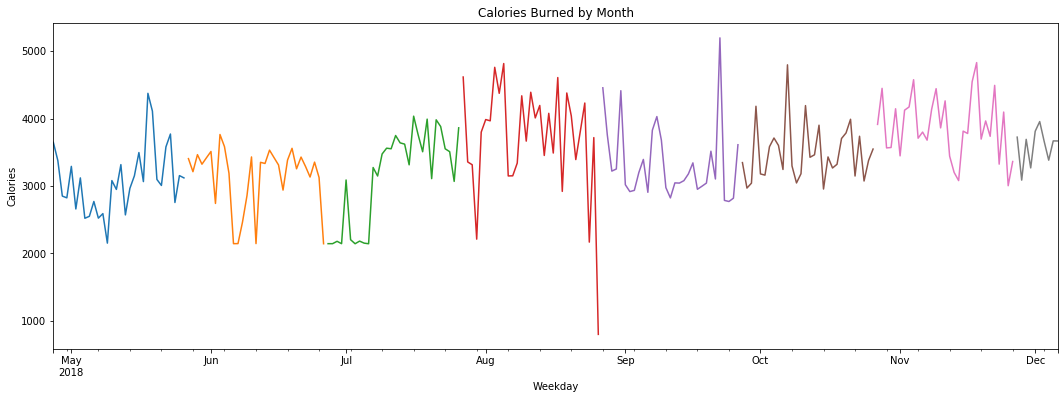

In [45]:
df['calories_burned']['2018-04-27':'2018-05-26'].plot(figsize= (18,6))
df['calories_burned']['2018-05-27':'2018-06-26'].plot()
df['calories_burned']['2018-06-27':'2018-07-26'].plot()
df['calories_burned']['2018-07-27':'2018-08-26'].plot()
df['calories_burned']['2018-08-27':'2018-09-26'].plot()
df['calories_burned']['2018-09-27':'2018-10-26'].plot()
df['calories_burned']['2018-10-27':'2018-11-26'].plot()
df['calories_burned']['2018-11-27':'2018-12-06'].plot()

plt.xlabel('Weekday')
plt.ylabel('Calories')
plt.title('Calories Burned by Month')
plt.show()

### Average Calories Burned by Weekday

In [42]:
df.groupby(['weekday']).calories_burned.mean()

weekday
0 Sun    3551.46875
1 Mon    3242.75000
2 Tue    3304.09375
3 Wed    3270.46875
4 Thu    3450.65625
5 Fri    3464.71875
6 Sat    3553.18750
Name: calories_burned, dtype: float64

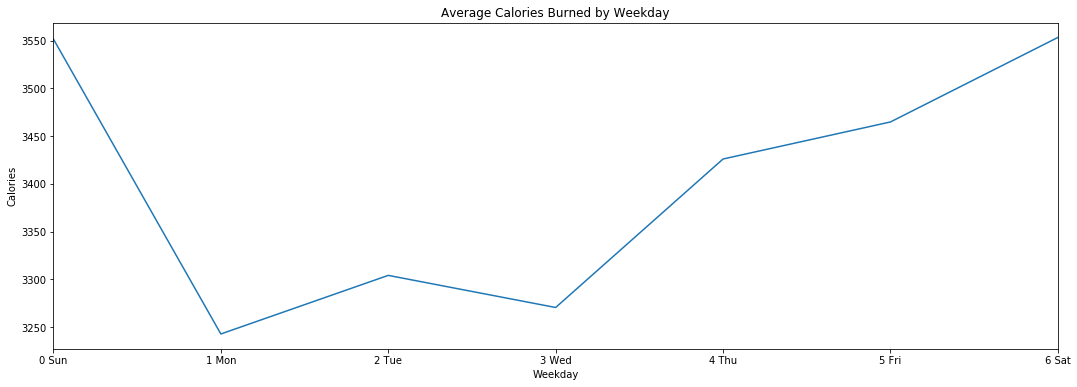

In [38]:
df.groupby(['weekday'])['calories_burned'].mean().plot(figsize = (18,6))

plt.xlabel('Weekday')
plt.ylabel('Calories')
plt.title('Average Calories Burned by Weekday')
plt.show()

### Number of Steps by Day

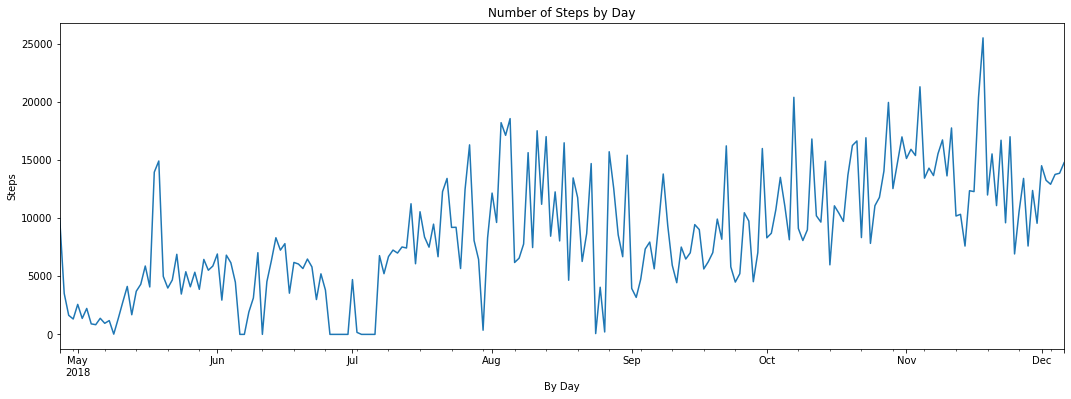

In [63]:
df['steps'].plot(figsize=(18,6))

plt.xlabel('By Day')
plt.ylabel('Steps')
plt.title('Number of Steps by Day')
plt.show()

### Drop Columns - Month and Weekday for Modeling

In [76]:
df.drop(columns=['month', 'weekday'], inplace=True)

KeyError: "['month' 'weekday'] not found in axis"

## Calculate Steps Rolling Average

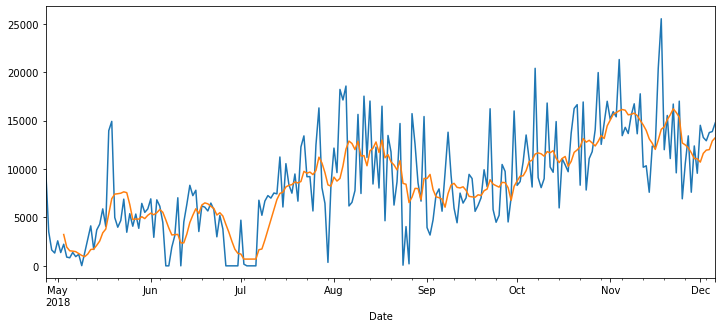

In [77]:
df['steps'].plot(figsize=(12,5))
df.rolling(window=7).mean()['steps'].plot()

In [78]:
df['steps_7_day_mean'] = df['steps'].rolling(window=7).mean()

In [79]:
df.head(10)

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,ratio_act_sed,ratio_steps_distance,ratio_cal_steps,ratio_active_cal,ratio_sed_cal,steps_7_day_mean
Date,,,,,,,,,,,,,,,,
2018-04-27,3649,9971,4.7,19,1158,219,46,17,1752,282,0.243523,2121.489362,0.365961,0.077281,0.317347,NaN
2018-04-28,3379,3521,1.7,2,702,155,22,11,1124,188,0.267806,2071.176471,0.959671,0.055638,0.207754,NaN
2018-04-29,2851,1639,0.8,0,891,122,0,0,602,122,0.136925,2048.750000,1.739475,0.042792,0.312522,NaN
2018-04-30,2825,1323,0.6,0,880,104,0,0,540,104,0.118182,2205.000000,2.135299,0.036814,0.311504,NaN
2018-05-01,3292,2581,1.2,0,919,167,13,2,1068,182,0.198041,2150.833333,1.275475,0.055286,0.279162,NaN
2018-05-02,2660,1372,0.7,0,927,90,0,0,419,90,0.097087,1960.000000,1.938776,0.033835,0.348496,NaN
2018-05-03,3121,2232,1.1,0,876,157,16,0,1006,173,0.197489,2029.090909,1.398297,0.055431,0.280679,3234.142857
2018-05-04,2522,904,0.4,1,1012,61,0,0,269,61,0.060277,2260.000000,2.789823,0.024187,0.401269,1938.857143
2018-05-05,2551,833,0.4,0,969,68,0,0,326,68,0.070175,2082.500000,3.062425,0.026656,0.379851,1554.857143


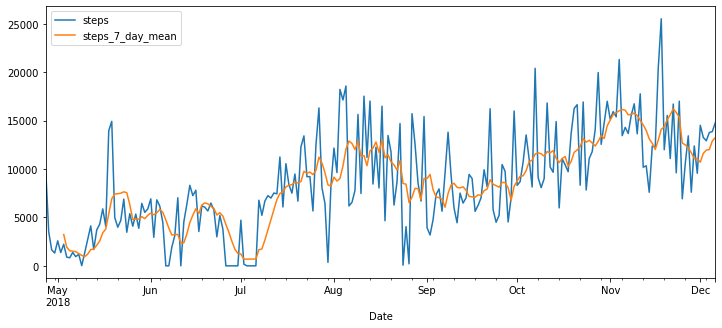

In [81]:
df[['steps', 'steps_7_day_mean']].plot(figsize=(12,5))

plt.show()

## Expanding Steps

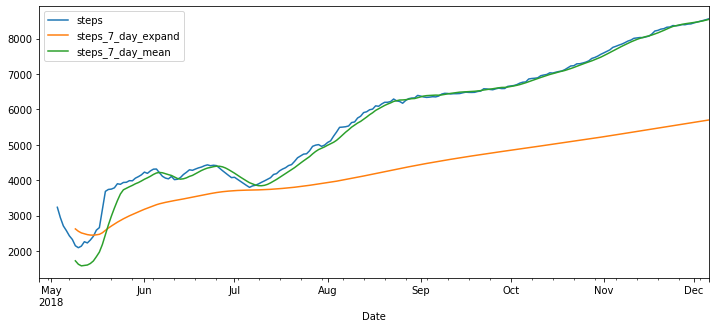

In [89]:
df[['steps', 'steps_7_day_expand', 'steps_7_day_mean']].expanding(min_periods=7).mean().plot(figsize=(12,5))

plt.show()

In [85]:
df['steps_7_day_expand'] = df['steps'].expanding(min_periods=7).mean()

In [86]:
df.head(10)

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,ratio_act_sed,ratio_steps_distance,ratio_cal_steps,ratio_active_cal,ratio_sed_cal,steps_7_day_mean,steps_7_day_expand
Date,,,,,,,,,,,,,,,,,
2018-04-27,3649,9971,4.7,19,1158,219,46,17,1752,282,0.243523,2121.489362,0.365961,0.077281,0.317347,NaN,NaN
2018-04-28,3379,3521,1.7,2,702,155,22,11,1124,188,0.267806,2071.176471,0.959671,0.055638,0.207754,NaN,NaN
2018-04-29,2851,1639,0.8,0,891,122,0,0,602,122,0.136925,2048.750000,1.739475,0.042792,0.312522,NaN,NaN
2018-04-30,2825,1323,0.6,0,880,104,0,0,540,104,0.118182,2205.000000,2.135299,0.036814,0.311504,NaN,NaN
2018-05-01,3292,2581,1.2,0,919,167,13,2,1068,182,0.198041,2150.833333,1.275475,0.055286,0.279162,NaN,NaN
2018-05-02,2660,1372,0.7,0,927,90,0,0,419,90,0.097087,1960.000000,1.938776,0.033835,0.348496,NaN,NaN
2018-05-03,3121,2232,1.1,0,876,157,16,0,1006,173,0.197489,2029.090909,1.398297,0.055431,0.280679,3234.142857,3234.142857
2018-05-04,2522,904,0.4,1,1012,61,0,0,269,61,0.060277,2260.000000,2.789823,0.024187,0.401269,1938.857143,2942.875000
2018-05-05,2551,833,0.4,0,969,68,0,0,326,68,0.070175,2082.500000,3.062425,0.026656,0.379851,1554.857143,2708.444444


# Model

# Forecast

# Final Takeaways

- Faith:


- Sean: